In [14]:
!conda install -y gdown

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2023.11.17         |     pyhd8ed1ab_1         155 KB  conda-forge
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.0.1                |     pyhd8ed1ab_0          20 KB  conda-forge
    openssl-3.2.1              |       hd590300_0         2.7 MB  conda-forge
    scipy-1.12.0               |  py310hb13e2d6

In [42]:
!gdown 1vXuN6h5pMha_dmU_mWhn2e1fsCANGoOT
!gdown 1HxoefWIplFdkKT6mPOFTO-aIrE788jRN

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading...
From (original): https://drive.google.com/uc?id=1vXuN6h5pMha_dmU_mWhn2e1fsCANGoOT
From (redirected): https://drive.google.com/uc?id=1vXuN6h5pMha_dmU_mWhn2e1fsCANGoOT&confirm=t&uuid=5c0fce17-38e3-46ea-ac55-3993931b1bfa
To: /kaggle/working/subtaskB_train.jsonl
100%|█████████████████████████████████████████| 155M/155M [00:00<00:00, 223MB/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading...
From: https://drive.google.com/uc?id=1HxoefWIplFdkKT6mPOFTO-aIrE788jRN
To: /kaggle/working/subtaskB_dev.jsonl
100%|███████████████████████████████████████| 4.93M/4.93M [00:00<00:00, 231MB/s]


In [97]:
# Import Required Packages
import torch.nn as nn
import torch
import random
import numpy as np
from transformers import AutoModel, AutoTokenizer
import json
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoConfig
import time
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import f1_score, classification_report

In [44]:
#------------------------------
#   Generator 1
#------------------------------
class Generator1(nn.Module):
    def __init__(self, noise_size=100, output_size=768, hidden_size=768, dropout_rate=0.8):
        super(Generator1, self).__init__()

        # Build layers sequentially
        layers = []

        # Linear transformation from noise to hidden_size
        layers.append(nn.Linear(noise_size, hidden_size))
        # Leaky ReLU activation
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        # Dropout layer
        layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))

        # Define the sequential model
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        # Forward pass through the layers
        output = self.layers(noise)
        return output

In [8]:
#------------------------------
#   Generator 2
#------------------------------
class Generator2(nn.Module):
    def __init__(self, bert_model, output_size=768, noise_size=100):
        super(Generator2, self).__init__()
        self.bert_model = bert_model
        self.output_size = output_size
        self.noise_size = noise_size

    def forward(self, bag_of_words):
        # Random noise
        noise = torch.randn((bag_of_words.size(0), self.noise_size))

        # Concatenate Bag of Words and Noise
        input_noise = torch.cat((bag_of_words, noise), dim=1)

        # BERT-based feature extraction
        bert_output = self.bert_model(input_noise)

        # Extract the pooled output (CLS token) from BERT
        pooled_output = bert_output.pooler_output

        # Linear transformation to the desired output size
        output = nn.Linear(pooled_output.size(1), self.output_size)(pooled_output)

        return output

In [45]:
#------------------------------
#   The Discriminator
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=768, hidden_size=768, num_labels=6, dropout_rate=0.8):
        super(Discriminator, self).__init__()

        # Input dropout
        self.input_dropout = nn.Dropout(p=dropout_rate)

        # Feature extraction layer
        self.feature_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate)
        )

        # Output layer for classification
        self.logit = nn.Linear(hidden_size, num_labels + 1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        # Apply input dropout
        input = self.input_dropout(input)

        # Forward pass through feature extraction layers
        feature = self.feature_layer(input)

        # Output layer
        logits = self.logit(feature)
        probs = self.softmax(logits)

        return feature, logits, probs

In [46]:
##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [47]:
# Check if CUDA (GPU) is available, and assign the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pre-trained BERT model name
model_name = "bert-base-cased"

# Load the pre-trained BERT model
transformer = AutoModel.from_pretrained(model_name)

# Load the corresponding tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [87]:
def parse_question_classification_file(input_file):
    examples = []

    with open(input_file, 'r') as f:
        # Iterate through each line in the JSONL file
        for line in f:
            # Parse the JSON from each line
            data = json.loads(line)

            # Extract relevant information
            text = data.get('text', '')
            label = data.get('label', '')
            model = data.get('model', '')

            examples.append((text, label, model))

    return examples



def generate_data_loader(examples, label_masks, label_map, max_seq_length=180, batch_size=32, do_shuffle=False):
    new_example = []
    for index, ex in enumerate(examples):
      new_example.append((ex, label_masks[index]))

    input_ids = []
    input_mask_array = []
    label_mask_array = []
    label_id_array = []

    # Tokenization
    for (ex, label_mask) in new_example:
        # Assuming tokenizer is predefined
        if ex[0] == '':
          print("qq")
        encoded_sent = tokenizer.encode(ex[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
        input_ids.append(encoded_sent)
        label_id_array.append(label_map.get(ex[2]))
        label_mask_array.append(label_mask)

    # Attention mask
    input_mask_array = [[int(token_id > 0) for token_id in sent] for sent in input_ids]

    # Convert to tensors
    input_ids = torch.tensor(input_ids)
    input_mask_array = torch.tensor(input_mask_array)
    label_id_array = torch.tensor(label_id_array)
    label_mask_array = torch.tensor(label_mask_array)

    # Building the TensorDataset
    dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

    # Choose sampler based on shuffle option
    sampler = RandomSampler if do_shuffle else SequentialSampler

    # Building the DataLoader
    return DataLoader(
        dataset,
        sampler=sampler(dataset),
        batch_size=batch_size
    )




def load_and_generate_data_loader(file_path, label_map, percentage_labeled, do_shuffle=False):
    # Load the examples
    examples = parse_question_classification_file(file_path)

    # Calculate the number of examples to be labeled
    num_labeled_examples = int(len(examples) * (percentage_labeled / 100))

    # Split the examples into labeled and unlabeled
    labeled_examples = examples[:num_labeled_examples]
    unlabeled_examples = examples[num_labeled_examples:]

    # The labeled dataset is assigned with a mask set to True
    label_masks = np.ones(len(labeled_examples), dtype=bool)

    # If unlabeled examples are available
    if unlabeled_examples:
        labeled_examples = labeled_examples + unlabeled_examples
        # The unlabeled dataset is assigned with a mask set to False
        tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
        label_masks = np.concatenate([label_masks, tmp_masks])

    # Generate DataLoaders
    dataloader = generate_data_loader(labeled_examples, label_masks, label_map, do_shuffle=do_shuffle)

    return dataloader

In [88]:
# Define the file paths
train_file_path = "subtaskB_train.jsonl"
test_file_path = "subtaskB_dev.jsonl"

# Assuming label_map is predefined
label_map = {"human": 0, "chatGPT": 1, "cohere": 2, "davinci": 3, "bloomz": 4, "dolly": 5}

# # Generate DataLoaders for training and testing for each percentage

train_dataloader_50 = load_and_generate_data_loader(train_file_path, label_map, 50, do_shuffle=True)
test_dataloader = load_and_generate_data_loader(test_file_path, label_map, 100, do_shuffle=False)


/tmp/ipykernel_34/1707988561.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


In [89]:
# Instantiate the Generator and Discriminator
generator1_1 = Generator1()
generator1_5 = Generator1()
generator1_10 = Generator1()
generator1_50 = Generator1()
discriminator_1 = Discriminator()
discriminator_5 = Discriminator()
discriminator_10 = Discriminator()
discriminator_50 = Discriminator()

# Put everything on the GPU if available
generator1_1.to(device)
generator1_5.to(device)
generator1_10.to(device)
generator1_50.to(device)
discriminator_1.to(device)
discriminator_5.to(device)
discriminator_10.to(device)
discriminator_50.to(device)
transformer.to(device)

multi_gpu = False

# Use DataParallel if multi_gpu is True
if multi_gpu and torch.cuda.is_available():
    generator1_1 = torch.nn.DataParallel(generator1_1)
    generator1_5 = torch.nn.DataParallel(generator1_5)
    generator1_10 = torch.nn.DataParallel(generator1_10)
    generator1_50 = torch.nn.DataParallel(generator1_50)
    discriminator_1 = torch.nn.DataParallel(discriminator_1)
    discriminator_5 = torch.nn.DataParallel(discriminator_5)
    discriminator_10 = torch.nn.DataParallel(discriminator_10)
    discriminator_50 = torch.nn.DataParallel(discriminator_50)

In [90]:
# Set Hyperparameters
learning_rate_discriminator = 5e-5
learning_rate_generator = 7e-4
epsilon = 1e-8
num_train_epochs = 5
print_each_n_step = 100

# Extract model parameters for Discriminator, Generator, and Transformer
transformer_vars = [i for i in transformer.parameters()]
d_vars_1 = [v for v in discriminator_1.parameters()]
d_vars_5 = [v for v in discriminator_5.parameters()]
d_vars_10 = [v for v in discriminator_10.parameters()]
d_vars_50 = [v for v in discriminator_50.parameters()]
g_vars_1 = [v for v in generator1_1.parameters()]
g_vars_5 = [v for v in generator1_5.parameters()]
g_vars_10 = [v for v in generator1_10.parameters()]
g_vars_50 = [v for v in generator1_50.parameters()]

# Set up optimizers for Discriminator and Generator
dis_optimizer_1 = torch.optim.AdamW(d_vars_1, lr=learning_rate_generator)
dis_optimizer_5 = torch.optim.AdamW(d_vars_5, lr=learning_rate_generator)
dis_optimizer_10 = torch.optim.AdamW(d_vars_10, lr=learning_rate_generator)
dis_optimizer_50 = torch.optim.AdamW(d_vars_50, lr=learning_rate_generator)
gen_optimizer_1 = torch.optim.AdamW(g_vars_1, lr=learning_rate_generator)
gen_optimizer_5 = torch.optim.AdamW(g_vars_5, lr=learning_rate_generator)
gen_optimizer_10 = torch.optim.AdamW(g_vars_10, lr=learning_rate_generator)
gen_optimizer_50 = torch.optim.AdamW(g_vars_50, lr=learning_rate_generator)




bert_optimizer_1 = torch.optim.AdamW(transformer_vars, lr=learning_rate_discriminator)
bert_optimizer_5 = torch.optim.AdamW(transformer_vars, lr=learning_rate_discriminator)
bert_optimizer_10 = torch.optim.AdamW(transformer_vars, lr=learning_rate_discriminator)
bert_optimizer_50 = torch.optim.AdamW(transformer_vars, lr=learning_rate_discriminator)

## Train with 50 % labeled data

In [91]:
test_accuracies = []
f1_scores = []

    
def train(transformer, generator1, discriminator, train_dataloader,test_dataloader, gen_optimizer, dis_optimizer, bert_optimizer, device, num_train_epochs, print_each_n_step=100, epsilon=1e-12):

    test_accuracy = 0
    f1 = 0

    for epoch_i in range(num_train_epochs):
        print(f"\n======== Epoch {epoch_i + 1} / {num_train_epochs} ========")

        tr_g_loss = 0
        tr_d_loss = 0

        # Set models to training mode
        transformer.train()
        generator1.train()
        discriminator.train()

        # Iterate through batches in the training dataloader
        for step, batch in enumerate(train_dataloader):
            # Display progress every print_each_n_step batches
            if step % print_each_n_step == 0 and not step == 0:
                print(f"  Batch {step:>5,}  of  {len(train_dataloader):>5,}.")

            # Move batch tensors to device
            b_input_ids, b_input_mask, b_labels, b_label_mask = [tensor.to(device) for tensor in batch]
            real_batch_size = b_input_ids.shape[0]

            # Forward pass through the transformer
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]

            # Generate fake data using the generator
            noise = torch.zeros(real_batch_size, 100, device=device).uniform_(0, 1)
            gen_rep = generator1(noise)

            # Concatenate real and fake data for the discriminator input
            discriminator_input = torch.cat([hidden_states, gen_rep], dim=0)
            features, logits, probs = discriminator(discriminator_input)

            # Split features, logits, and probs for real and fake data
            features_list = torch.split(features, real_batch_size)
            D_real_features, D_fake_features = features_list[0], features_list[1]

            logits_list = torch.split(logits, real_batch_size)
            D_real_logits, D_fake_logits = logits_list[0], logits_list[1]

            probs_list = torch.split(probs, real_batch_size)
            D_real_probs, D_fake_probs = probs_list[0], probs_list[1]

            # Generator's loss calculation
            g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:, -1] + epsilon))
            g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
            g_loss = g_loss_d + g_feat_reg

            # Discriminator's loss calculation
            logits = D_real_logits[:, 0:-1]
            log_probs = F.log_softmax(logits, dim=-1)
            label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_map))
            per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
            per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
            labeled_example_count = per_example_loss.type(torch.float32).numel()

            D_L_Supervised = 0 if labeled_example_count == 0 else torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
            D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
            D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
            d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

            # Backward pass and optimization
            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            bert_optimizer.zero_grad()
            g_loss.backward(retain_graph=True)
            d_loss.backward()
            gen_optimizer.step()
            dis_optimizer.step()
            bert_optimizer.step()
            

            # Update loss accumulators
            tr_g_loss += g_loss.item()
            tr_d_loss += d_loss.item()

        # Calculate average training losses
        avg_train_loss_g = tr_g_loss / len(train_dataloader)
        avg_train_loss_d = tr_d_loss / len(train_dataloader)

        # Print average training losses for the epoch
        print("\n  Average training loss generator: {:.3f}".format(avg_train_loss_g))
        print("  Average training loss discriminator: {:.3f} \n\n".format(avg_train_loss_d))
        test_accuracy, avg_test_loss, f1 = test(transformer, discriminator, test_dataloader, device)
        print("\n  Accuracy on Test Set: {:.3f}".format(test_accuracy))
        print("  Average Test Loss: {:.3f}".format(avg_test_loss))
        print("  F1 Score on Test Set: {:.3f}".format(f1))
        
        
    return test_accuracy, f1


def test(transformer, discriminator, test_dataloader, device):


    # Set models to evaluation mode
    transformer.eval()
    discriminator.eval()

    # Initialize variables for test evaluation
    total_test_accuracy = 0
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    # Define the loss function for evaluation
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Iterate through the test dataloader
    for batch in test_dataloader:
        # Move batch tensors to the device (GPU or CPU)
        b_input_ids, b_input_mask, b_labels, _ = [tensor.to(device) for tensor in batch]

        # Perform forward pass without gradient computation
        with torch.no_grad():
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)

            # Extract logits for labeled classes (excluding the fake class)
            filtered_logits = logits[:, 0:-1]
            total_test_loss += nll_loss(filtered_logits, b_labels)

        # Calculate accuracy and accumulate predictions and labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Convert accumulated predictions and labels to NumPy arrays
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()

    # Calculate accuracy and average test loss
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()

    # Calculate F1 score
    f1 = f1_score(all_labels_ids, all_preds, average='weighted')

    return test_accuracy, avg_test_loss, f1




In [92]:
test_acc, f1 = train(transformer, generator1_50, discriminator_50, train_dataloader_50,test_dataloader, gen_optimizer_50, dis_optimizer_50, bert_optimizer_50,device, num_train_epochs, print_each_n_step=100, epsilon=1e-12)
f1_scores.append(f1)
test_accuracies.append(test_acc)


======== Epoch 1 / 5 ========
  Batch   100  of  2,220.
  Batch   200  of  2,220.
  Batch   300  of  2,220.
  Batch   400  of  2,220.
  Batch   500  of  2,220.
  Batch   600  of  2,220.
  Batch   700  of  2,220.
  Batch   800  of  2,220.
  Batch   900  of  2,220.
  Batch 1,000  of  2,220.
  Batch 1,100  of  2,220.
  Batch 1,200  of  2,220.
  Batch 1,300  of  2,220.
  Batch 1,400  of  2,220.
  Batch 1,500  of  2,220.
  Batch 1,600  of  2,220.
  Batch 1,700  of  2,220.
  Batch 1,800  of  2,220.
  Batch 1,900  of  2,220.
  Batch 2,000  of  2,220.
  Batch 2,100  of  2,220.
  Batch 2,200  of  2,220.

  Average training loss generator: 0.740
  Average training loss discriminator: 1.618 



  Accuracy on Test Set: 0.478
  Average Test Loss: 1.951
  F1 Score on Test Set: 0.415

======== Epoch 2 / 5 ========
  Batch   100  of  2,220.
  Batch   200  of  2,220.
  Batch   300  of  2,220.
  Batch   400  of  2,220.
  Batch   500  of  2,220.
  Batch   600  of  2,220.
  Batch   700  of  2,220.
  Batc

## Train with 10 % labeled data

In [ ]:
train_dataloader_10 = load_and_generate_data_loader(train_file_path, label_map, 10, do_shuffle=True)
num_train_epochs = 3
test_acc2, f1_2 = train(transformer, generator1_10, discriminator_10, train_dataloader_10,test_dataloader, gen_optimizer_10, dis_optimizer_10, bert_optimizer_10,device, num_train_epochs, print_each_n_step=100, epsilon=1e-12)
f1_scores.append(f1_2)
test_accuracies.append(test_acc2)

/tmp/ipykernel_34/1707988561.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)



======== Epoch 1 / 3 ========
  Batch   100  of  2,220.
  Batch   200  of  2,220.
  Batch   300  of  2,220.
  Batch   400  of  2,220.
  Batch   500  of  2,220.
  Batch   600  of  2,220.
  Batch   700  of  2,220.
  Batch   800  of  2,220.
  Batch   900  of  2,220.
  Batch 1,000  of  2,220.
  Batch 1,100  of  2,220.
  Batch 1,200  of  2,220.
  Batch 1,300  of  2,220.
  Batch 1,400  of  2,220.
  Batch 1,500  of  2,220.
  Batch 1,600  of  2,220.
  Batch 1,700  of  2,220.
  Batch 1,800  of  2,220.
  Batch 1,900  of  2,220.
  Batch 2,000  of  2,220.
  Batch 2,100  of  2,220.
  Batch 2,200  of  2,220.

  Average training loss generator: 0.731
  Average training loss discriminator: 1.152 



  Accuracy on Test Set: 0.248
  Average Test Loss: 2.637
  F1 Score on Test Set: 0.170

======== Epoch 2 / 3 ========
  Batch   100  of  2,220.
  Batch   200  of  2,220.
  Batch   300  of  2,220.
  Batch   400  of  2,220.
  Batch   500  of  2,220.
  Batch   600  of  2,220.
  Batch   700  of  2,220.
  Batc

## Train with 5 % labeled data

In [ ]:
train_dataloader_5 = load_and_generate_data_loader(train_file_path, label_map, 5, do_shuffle=True)
num_train_epochs = 2
test_acc3, f1_3 = train(transformer, generator1_5, discriminator_5, train_dataloader_5,test_dataloader, gen_optimizer_5, dis_optimizer_5, bert_optimizer_5,device, num_train_epochs, print_each_n_step=100, epsilon=1e-12)
f1_scores.append(f1_3)
test_accuracies.append(test_acc3)

/tmp/ipykernel_34/1707988561.py:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)



======== Epoch 1 / 2 ========
  Batch   100  of  2,220.
  Batch   200  of  2,220.
  Batch   300  of  2,220.
  Batch   400  of  2,220.
  Batch   500  of  2,220.
  Batch   600  of  2,220.
  Batch   700  of  2,220.
  Batch   800  of  2,220.
  Batch   900  of  2,220.
  Batch 1,000  of  2,220.
  Batch 1,100  of  2,220.
  Batch 1,200  of  2,220.
  Batch 1,300  of  2,220.
  Batch 1,400  of  2,220.
  Batch 1,500  of  2,220.
  Batch 1,600  of  2,220.
  Batch 1,700  of  2,220.
  Batch 1,800  of  2,220.
  Batch 1,900  of  2,220.
  Batch 2,000  of  2,220.
  Batch 2,100  of  2,220.
  Batch 2,200  of  2,220.

  Average training loss generator: 0.736
  Average training loss discriminator: 1.299 



  Accuracy on Test Set: 0.167
  Average Test Loss: 4.997
  F1 Score on Test Set: 0.048

======== Epoch 2 / 2 ========
  Batch   100  of  2,220.
  Batch   200  of  2,220.
  Batch   300  of  2,220.
  Batch   400  of  2,220.
  Batch   500  of  2,220.
  Batch   600  of  2,220.
  Batch   700  of  2,220.
  Batc

## Train with 1 % labeled data

In [1]:
train_dataloader_1 = load_and_generate_data_loader(train_file_path, label_map, 1, do_shuffle=True)
num_train_epochs = 1
test_acc4, f1_4 = train(transformer, generator1_5, discriminator_5, train_dataloader_5,test_dataloader, gen_optimizer_5, dis_optimizer_5, bert_optimizer_5,device, num_train_epochs, print_each_n_step=100, epsilon=1e-12)
f1_scores.append(f1_4)
test_accuracies.append(test_acc4)

NameError: name 'load_and_generate_data_loader' is not defined

NameError: name 'test_accuracies' is not defined

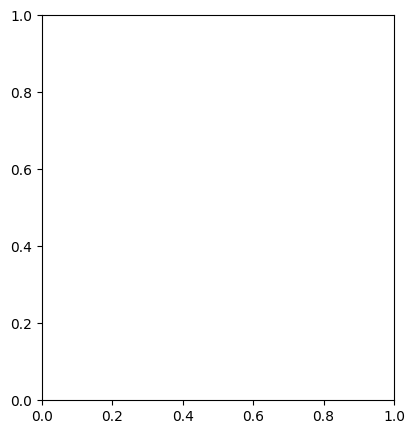

In [2]:
import matplotlib.pyplot as plt

# Assuming the dataloader indices are 50, 10, 5, and 1
dataloader_indices = [50, 10, 5, 1]

plt.figure(figsize=(10, 5))

# Plotting Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(dataloader_indices, test_accuracies, marker='o')
plt.title('Test Accuracy vs. Dataloader Index')
plt.xlabel('Dataloader Index')
plt.ylabel('Test Accuracy')

# Plotting F1 Score
plt.subplot(1, 2, 2)
plt.plot(dataloader_indices, f1_scores, marker='o')
plt.title('F1 Score vs. Dataloader Index')
plt.xlabel('Dataloader Index')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()